#### AIM: check how h5 timeseries fiels are processed in merge_cfact.py and why the cfact data is getting lost during the process

In [77]:
#!/usr/bin/env python3

# coding: utf-8

import os
import glob
import math
import itertools as it
from pathlib import Path
import netCDF4 as nc
import numpy as np
import pandas as pd
from datetime import datetime
import subprocess
import attrici.postprocess as pp
import settings as s
from matplotlib import pyplot as plt 



In [78]:
os.getcwd()
s.variable = "hurs"
s.lateral_sub = 1

s.output_dir = Path("/mnt/c/Users/Anna/Documents/UNI/PIK/develop/test_output")
s.input_dir = "/mnt/c/Users/Anna/Documents/UNI/PIK/develop/test_input/"
#s.source_file = f"{s.variable}_gswp3-w5e5_sub40.nc4"
s.source_file = f"{s.variable}_gswp3-w5e5_merged.nc4"

In [79]:
def round_float_down(num, step=0):
    '''
    Takes a float and rounds it always down to user-defined decimal place
    params: num : foat number
    params: step : decimal place
    return: float
    Copyied from : https://stackoverflow.com/questions/9404967/taking-the-floor-of-a-float
    '''
    if not step:
        return math.floor(num)
    if step < 0:
        mplr = 10 ** (step * -1)
        return math.floor(num / mplr) * mplr
    ncnt = step
    if 1 > step > 0:
        ndec, ncnt = .0101, 1
        while ndec > step:
            ndec *= .1
            ncnt += 1
    mplr = 10 ** ncnt
    return round(math.floor(num * mplr) / mplr, ncnt)


## TODO: make this more robust, so that also a regional AOI with subsets (e.g 40) is usable 
def rescale_squared_aoi(coord_list, coord_float):
    '''
    Rescales squared aoi, returns rescaled indices latitude or longitude
    params: coord_list: list of floats, list of lat or lon coordinates of the aoi
    params: coord_float: float, latitude or longitude derived from timeseries filename
    return: integer
    '''
    ## get correct amount of indices by rounding down always the minimum extent and round up the maximum extent
    coord_min = round_float_down(min(coord_list), 2) 
    coord_max = math.ceil(max(coord_list)*100) / 100 

    ## Formular: (new_max - new_min) / (old_max - old_min) * (v - old_min) + new_min
    coord_indice = int( (coord_list.shape[0] - 0) / ( coord_max - coord_min) * (coord_float - coord_min) + 0 )
    # org:  coord_indice = int( (coord_list.shape[0] - 0) / ( coord_max - coord_min) * (coord_float - coord_min) + 0 )

    return coord_indice
    


In [80]:
# options for postprocess
rechunk = False
# cdo_processing needs rechunk
cdo_processing = False

TIME0 = datetime.now()


print(s.variable)
ts_dir = s.output_dir / "timeseries" / s.variable
cfact_dir = s.output_dir / "cfact" /   s.variable

data_gen = ts_dir.glob("**/*" + s.storage_format)
print(ts_dir)
cfact_dir.mkdir(parents=True, exist_ok=True)
cfact_file = cfact_dir / s.cfact_file


### access data from source file
#obs = nc.Dataset(s.source_file, "r")
obs = nc.Dataset(Path(s.input_dir) / s.dataset / s.source_file.lower(), "r")
time = obs.variables["time"][:]
lat = obs.variables["lat"][:]
lon = obs.variables["lon"][:]

lat


hurs
/mnt/c/Users/Anna/Documents/UNI/PIK/develop/test_output/timeseries/hurs


masked_array(data=[44.10833333, 44.09166667, 44.075     , 44.05833333,
                   44.04166667, 44.025     , 44.00833333, 43.99166667,
                   43.975     , 43.95833333, 43.94166667, 43.925     ,
                   43.90833333, 43.89166667, 43.875     , 43.85833333,
                   43.84166667, 43.825     , 43.80833333, 43.79166667,
                   43.775     ],
             mask=False,
       fill_value=1e+20)

In [81]:
### check which data is available
data_list = []
lat_indices = []
lon_indices = []

for i in data_gen:
    data_list.append(str(i))
    lat_float = float(str(i).split("lat")[-1].split("_")[0])
    lon_float = float(str(i).split("lon")[-1].split(s.storage_format)[0])

    ## squared extent of AOI (rescaling needed)   
    if s.lateral_sub == 1 :
        #min_lat = math.ceil(min(lat)*100) / 100  # test: round up
        min_lat = round_float_down(min(lat), 3) 
        max_lat = math.ceil(max(lat)*100) / 100
        min_lon = round_float_down(min(lon), 3) 
        max_lon = math.ceil(max(lon)*100) / 100
        
        lat_indices.append(
            int( (lat.shape[0] - 0) / ( max_lat - min_lat) * (lat_float - min_lat) + 0 )
        )
        lon_indices.append(
            int( (lon.shape[0] - 0) / ( max_lon - min_lon) * (lon_float - min_lon) + 0)
        )
        #lat_indices =  np.arange(21) 
        #lon_indices =  np.arange(21) 


        #lat_indices.append( rescale_squared_aoi(lat, lat_float ))
        #lon_indices.append( rescale_squared_aoi(lon, lon_float ))

    ## rectangular extent of AOI (no rescaling needed)
    else:  
        lat_indices.append(int(180 - 2 * lat_float - 0.5))
        lon_indices.append(int(2 * lon_float - 0.5 + 360))

    
print(len(lat_indices), len(lon_indices) )  # shape 51 x 51 (org sub40))
print(len(np.unique(lat_indices)), len(np.unique(lon_indices)) )  # 7 x 16 (org sub40)
print(np.unique(lat_indices))
print(np.unique(lon_indices))  

# 51 51
# 7 16
# [ 40  80 120 160 200 240 320]
# [ 40  80 120 160 200 240 280 360 400 440 480 520 560 600 640 680]

## Cfactual should have shape of:
## same len of indidces and unique values as ORG_merged
# 416 416
# 21 21
# [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
# [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


## DOESNT WORK
## keep number of indieces same, but make value shift -1 lower values in lat [0-20], <-> lon[1-21]

21 21
21 21
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [82]:
#lat_indices.append(int((lat.shape[0] - 0) / ( 44.11 - min(lat)) * (lat_float - min(lat)) + 0)) 
#lon_indices.append(int((lon.shape[0] - 0) / ( 7.83 - min(lon)) * (lon_float - min(lon)) + 0))
# lat: 43.77499999999998, 44.108333333333306, lon: 7.492666666666699 7.825000000000035
#        43.775  , 44.11 ,   7.83  ,   7.493

#print(lat, round_float_down(min(lat), 3) )


In [83]:
# print(min(lat_indices), min(lon_indices) )  # 40 40  (org sub40)
# print(max(lat_indices), max(lon_indices) )  # 320 680 (org sub40)
# # #print(lat_indices, lon_indices)
# #     # 360/720  (lat / lon shapes)

# print(len(lat_indices)) # 51
# print(len(lon_indices)) # 51
# #print(lat_indices)  # lat: 43.77499999999998, 44.108333333333306, lon: 44.108333333333306 7.825000000000035
# # #np.unique(lon_indices)

# for i in np.nditer(lat):
#     print(i)

In [84]:
# lat_float
# #lon_indices

# #lon_indices.shape  # 416
# #lat_indices.shape  # 416

# #lon_indices  # 374, 375
# #lat_indices  # 91
print(s.lateral_sub)
print(s.variable)

#pd.Series(lat_indices).value_counts() # 6mal 0s, 14mal 1s, 21mal 20s

1
hurs


In [85]:


# adjust indices if datasets are subsets (lat/lon-shapes are smaller than 360/720)
# TODO: make this more robust
lat_indices = np.array(lat_indices) / s.lateral_sub
lon_indices = np.array(lon_indices) / s.lateral_sub

#print(lat_indices, lon_indices)
# ### access data from source file
# #obs = nc.Dataset(Path(s.input_dir) / s.source_file.lower(), "r")
# obs = nc.Dataset(Path(s.input_dir) / s.dataset / s.source_file.lower(), "r")
# time = obs.variables["time"][:]
# lat = obs.variables["lat"][:]
# lon = obs.variables["lon"][:]


In [86]:
# pd.Series(lat_indices).value_counts()
data_list[0]
# lat43.77499999999998_lon7.491666666666699.h5


'/mnt/c/Users/Anna/Documents/UNI/PIK/develop/test_output/timeseries/hurs/lat_43.77499999999998/ts_GSWP3-W5E5_lat43.77499999999998_lon7.491666666666699.h5'

In [87]:
if s.lateral_sub == 1 :
    lat_indices = lat_indices[: : -1]  # undone flip of spatial extent

#lat_indices = np.flip(lat_indices)  # same shift 

In [88]:
#pd.Series(lat_indices).value_counts()
lat_indices = lat_indices.astype(int)
lon_indices = lon_indices.astype(int)

In [89]:
## ORG lon_indices:
# [ 7.  6. 15. 10. 11.  6. 15. 16. 10.  9. 14. 15. 16. 17. 10. 11. 12. 13.
#   4.  9. 14. 15. 10. 12. 13.  3.  5.  4.  9. 14. 15. 16. 10. 11. 12. 13.
#   2.  1.  7.  5. 14. 15. 16. 17. 10. 12. 13.  9. 10. 11. 13.]


# Modified lon_indices by my func
# lon_indices

# array([0.175, 0.15 , 0.375, 0.25 , 0.275, 0.15 , 0.375, 0.4  , 0.25 ,
#        0.225, 0.35 , 0.375, 0.4  , 0.45 , 0.25 , 0.275, 0.3  , 0.325,
#        0.1  , 0.225, 0.35 , 0.375, 0.25 , 0.3  , 0.325, 0.075, 0.125,
#        0.1  , 0.225, 0.35 , 0.375, 0.4  , 0.25 , 0.275, 0.3  , 0.325,
#        0.05 , 0.025, 0.175, 0.125, 0.35 , 0.375, 0.4  , 0.45 , 0.25 ,
#        0.3  , 0.325, 0.225, 0.25 , 0.275, 0.325])

lat#np.where(lat == lat.min())

masked_array(data=[44.10833333, 44.09166667, 44.075     , 44.05833333,
                   44.04166667, 44.025     , 44.00833333, 43.99166667,
                   43.975     , 43.95833333, 43.94166667, 43.925     ,
                   43.90833333, 43.89166667, 43.875     , 43.85833333,
                   43.84166667, 43.825     , 43.80833333, 43.79166667,
                   43.775     ],
             mask=False,
       fill_value=1e+20)

In [90]:

# append later with more variables if needed
variables_to_report = {s.variable: "cfact", s.variable + "_orig": "y"}


#  get headers and form empty netCDF file with all meatdata
headers = pp.read_from_disk(data_list[0]).keys()
#headers = headers.drop(["t", "ds", "gmt", "gmt_scaled"])  # org
#headers = headers.drop(["ds", "y", "logp"])
# test without : headers = headers.drop(['ds', 'y','logp']) 
print(headers)

cfact_file = cfact_dir / f"{s.variable}_test_sub1_5_6.nc4"
out = nc.Dataset(cfact_file, "w", format="NETCDF4")
pp.form_global_nc(out, time, lat, lon, headers, obs.variables["time"].units)


Index(['ds', 'y', 'cfact', 'logp'], dtype='object')


In [91]:
#data_list = data_list [::-1]
## ORG data_list order with two top entries:
#W5E5_lat43.77499999999998_lon7.491666666666699.h5',
#W5E5_lat43.77499999999998_lon7.508333333333372.h5',
#t43.77499999999998_lon7.491


## AIM: flip only lat values but keep lon in unchanged order
#lat_indices = lat_indices[::-1] #[:3]
#lat_indices = list(map(lambda x:x+1, lat_indices))

#ts#.unique()
i

PosixPath('/mnt/c/Users/Anna/Documents/UNI/PIK/develop/test_output/timeseries/hurs/lat_44.108333333333306/ts_GSWP3-W5E5_lat44.108333333333306_lon7.825000000000035.h5')

In [92]:
print(headers)

for (i, j, dfpath) in it.zip_longest(lat_indices, lon_indices, data_list):
    df = pp.read_from_disk(dfpath)
    
    for head in headers:
        # if head == "cfact":
        ts = df[head]
        out.variables[head][ :, i, j] = np.array(ts)
        #out.variables[head][ :, i, j] = np.flip(np.array(ts))
        #out.variables[head][ :, i, j] = np.flip(out.variables[head][ :, i, j]) # doesnt burn into out.file permanent

    print("wrote data from", dfpath, "to", i, j)
    

## flip bottom to top
# gdal_command_flip = f"gdal_translate -of netCDF -co WRITE_BOTTOMUP=YES {s.variable}_test_sub1_4_1.nc4 {s.variable}_flippedLat.nc4"
# os.system(gdal_command_flip)

#out.close()

#43.77499999999998_lon7.508333333333372

## fehlt vllt beim schreiben die erste datenreihe? da die erste lat zu niedrig ist- müsste eher genau ursp. lat sein  -- NOPE 
## output.pynb: scheint so dass 20.0 0 bis 20.0 13.0 überschrieben # wird ebenso 19.0 0.0 bis 19.0 3.0 --> vgl mit sub40 = teils auch doubles
## flip out.nc ( not used []::-1])


Index(['ds', 'y', 'cfact', 'logp'], dtype='object')
wrote data from /mnt/c/Users/Anna/Documents/UNI/PIK/develop/test_output/timeseries/hurs/lat_43.77499999999998/ts_GSWP3-W5E5_lat43.77499999999998_lon7.491666666666699.h5 to 20 0
wrote data from /mnt/c/Users/Anna/Documents/UNI/PIK/develop/test_output/timeseries/hurs/lat_43.77499999999998/ts_GSWP3-W5E5_lat43.77499999999998_lon7.508333333333372.h5 to 19 1
wrote data from /mnt/c/Users/Anna/Documents/UNI/PIK/develop/test_output/timeseries/hurs/lat_43.77499999999998/ts_GSWP3-W5E5_lat43.77499999999998_lon7.558333333333369.h5 to 18 2
wrote data from /mnt/c/Users/Anna/Documents/UNI/PIK/develop/test_output/timeseries/hurs/lat_43.77499999999998/ts_GSWP3-W5E5_lat43.77499999999998_lon7.641666666666705.h5 to 17 3
wrote data from /mnt/c/Users/Anna/Documents/UNI/PIK/develop/test_output/timeseries/hurs/lat_43.77499999999998/ts_GSWP3-W5E5_lat43.77499999999998_lon7.6583333333333705.h5 to 16 4
wrote data from /mnt/c/Users/Anna/Documents/UNI/PIK/develop/te

IndexError: only integers, slices (`:`), ellipsis (`...`), and 1-d integer or boolean arrays are valid indices

In [94]:
#out.variables["cfact"] = np.flip(out.variables["cfact"])
# out.close()


1

In [138]:
# try:
#     #command_flip  = f"cdo invertlatdata {cfact_file} /mnt/c/Users/Anna/Documents/UNI/PIK/develop/test_output/cfact/hurs/out_flippedLat_nb.nc4"
#     command_flip = f"gdal_translate -of netCDF -co WRITE_BOTTOMUP=YES {cfact_file} out_flippedLat_gdal_nb.nc4"
#     print(command_flip)
#     subprocess.check_call(command_flip, shell=True)
# except subprocess.CalledProcessError:
#     # command_flip = "module load gdal && " + command_flip
#     print(command_flip)
#     subprocess.check_call(command_flip, shell=True)



In [139]:
#out_t = out#.variables["cfact"][ 8, :, :]
#out.variables["cfact"] = np.flip(out.variables["cfact"])


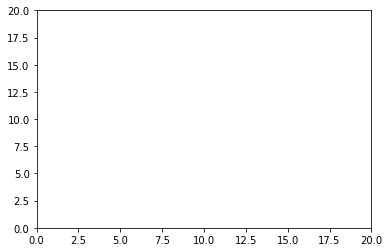

In [96]:
plt.contourf(out.variables["cfact"][ 0, :, :])


In [76]:
out.close()


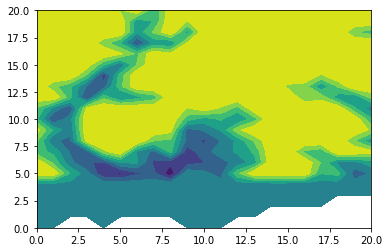

In [185]:
plt.contourf(out.variables["y"][ 8, :, :])

In [100]:
out.close()


AttributeError: 'MaskedArray' object has no attribute 'close'

In [35]:
## make lat_indeces that number of 0s is same as number of 20s in old lat_indices
pd.Series(lat_indices).value_counts()

## OR
## make datalist that only order of lats is reversed, not of lons
### ie   lat1, lon1   ,   lat2, lon2   , lat3, lon3  ... nth
###  --> lat3, lon1   ,   lat2, lon2   , lat1, lon3  .. nth

10.0    21
11.0    21
19.0    21
18.0    21
17.0    21
16.0    21
15.0    21
14.0    21
13.0    21
12.0    21
20.0    21
9.0     21
8.0     21
7.0     21
6.0     21
5.0     21
4.0     21
3.0     21
2.0     18
1.0     14
0.0      6
dtype: int64

In [ ]:
## RESTE

In [91]:
## test only with cfact = head


# for (i, j, dfpath) in it.zip_longest(lat_indices, lon_indices, data_list):

#     df = pp.read_from_disk(dfpath)
#     for head in headers:
#         head ="cfact"
#         print(i, j)
#         ts = df[head]
#         out.variables[head][:, i, j] = np.array(ts)
#     #print("wrote data from", dfpath, "to", i, j)

# out.close()
# print("Successfully wrote", cfact_file, "file. Took")
# print("It took {0:.1f} minutes.".format((datetime.now() - TIME0).total_seconds() / 60))


In [259]:
ncf = nc.Dataset(f"/mnt/c/Users/Anna/Documents/UNI/PIK/hpc/output_test/cfact/hurs/hurs_test7.nc4", "r")
ncf.close()
#ncf.variables

In [258]:
np.squeeze(ncf.variables["cfact"][:])

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, 67.03939819335938, 67.03939819335938, ..., --, --, --],
         [--, 67.03939819335938, 67.03939819335938, ...,
          61.868350982666016, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, 70.62744903564453, 70.62744903564453, ..., --, --, --],
         [--, 70.62744903564453, 70.62744903564453, ...,
          65.06389617919922, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, 76.68173217773438, 76.68173217773438, ..., --, --, --],
         [--, 76.68173217773438, 76.68173217773438, ...,
          73.73005676269531, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
    

In [91]:
# ts.shape  #len 25932
# out.variables[head][ :, 3, 3] = np.array(ts)
# out.variables[head][ :, 3.0, 3.0]
# #out.variables#["ds"][:4]
# #np.array(ts)[10598:,]

#out.variables#[head]#[:, i, j]

masked_array(data=[67.0394 , 70.62745, 76.68173, ..., 69.70887, 69.82759,
                   66.25824],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [77]:
df

,ds,y,cfact,logp
0,1950-01-01 00:30:00,67.036102,67.039398,8.842037
1,1950-01-02 00:00:00,70.625092,70.627448,8.842037
2,1950-01-03 00:00:00,76.680359,76.681732,8.842037
3,1950-01-04 00:00:00,67.510025,67.510654,8.842037
4,1950-01-05 00:00:00,80.589287,80.589056,8.842037
...,...,...,...,...
25928,2020-12-27 00:00:00,58.250774,58.926831,8.842037
25929,2020-12-28 00:00:00,74.442665,74.990903,8.842037
25930,2020-12-29 00:00:00,69.187439,69.708870,8.842037
25931,2020-12-30 00:00:00,69.370735,69.827595,8.842037


In [ ]:

out.close()
print("Successfully wrote", cfact_file, "file. Took")
print("It took {0:.1f} minutes.".format((datetime.now() - TIME0).total_seconds() / 60))

if rechunk:
    cfact_rechunked = pp.rechunk_netcdf(cfact_file)


In [ ]:

if cdo_processing:
    cdo_ops = {
        "monmean": "monmean -selvar,cfact,y",
        "yearmean": "yearmean -selvar,cfact,y",
        #    "monmean_valid": "monmean -setrtomiss,-1e20,1.1574e-06 -selvar,cfact,y",
        #    "yearmean_valid": "yearmean -setrtomiss,-1e20,1.1574e-06 -selvar,cfact,y",
        "trend": "trend -selvar,cfact,y",
        #    "trend_valid": "trend -setrtomiss,-1e20,1.1574e-06 -selvar,cfact,y",
    }

    for cdo_op in cdo_ops:

        outfile = str(cfact_file).rstrip(".nc4") + "_" + cdo_op + ".nc4"
        print(outfile)
        if "trend" in cdo_op:
            outfile = (
                outfile.rstrip(".nc4") + "_1.nc4 " + outfile.rstrip(".nc4") + "_2.nc4"
            )
        try:
            cmd = "cdo " + cdo_ops[cdo_op] + " " + cfact_rechunked + " " + outfile
            print(cmd)
            subprocess.check_call(cmd, shell=True)
        except subprocess.CalledProcessError:
            cmd = "module load cdo && " + cmd
            print(cmd)
            subprocess.check_call(cmd, shell=True)
